# MPT

Our null hypothesis asserts that the Mexican stocks originate from a population that is normally distributed as determined by the D’Agostino’s K^2 Test. If $p_{value} > 0.1$ for a given stock we fail to reject $H_0$, otherwise we reject the null hypothesis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import os

stocks = glob.glob(os.path.join('datasets', 'stocks', '*'))
dfs = [pd.read_json(stock) for stock in stocks]
stock_names = [os.path.basename(stock).split('.')[0] for stock in stocks]
dfs[0]

,price,import,date
0,43.49,1.326617e+07,2010-01-04
1,43.50,3.752885e+07,2010-01-05
2,43.30,1.132790e+07,2010-01-06
3,43.49,1.697124e+07,2010-01-07
4,42.90,1.107876e+07,2010-01-08
...,...,...,...
3427,158.42,2.182241e+08,2023-08-15
3428,162.78,3.064302e+08,2023-08-16
3429,163.12,2.762433e+08,2023-08-17
3430,162.50,1.508466e+08,2023-08-18


In [64]:
from scipy.stats import normaltest
results = [normaltest(df['price']) for df in dfs]
hypothesis_results=[[value, results[index].statistic, results[index].pvalue] for index, value in enumerate(stock_names)]
df=pd.DataFrame(hypothesis_results, columns=['Stock', 'Statistic', 'Pvalue'])
df

,Stock,Statistic,Pvalue
0,AC,5.639216,5.962931e-02
1,ACCELSAB,6878.182017,0.000000e+00
2,ACTINVRB,13.651812,1.085292e-03
3,AGRO22,278.631912,3.132197e-61
4,AGUA,128.485227,1.258309e-28
...,...,...,...
95,GSANBORB-1,30.776500,2.074760e-07
96,HCITY,17564.123365,0.000000e+00
97,HERDEZ,359.027679,1.091767e-78
98,HOMEX,713.692796,1.055792e-155


## Analysis

We reject the null hypothesis.

In [65]:
df[df['Pvalue'] > 0.1]

,Stock,Statistic,Pvalue


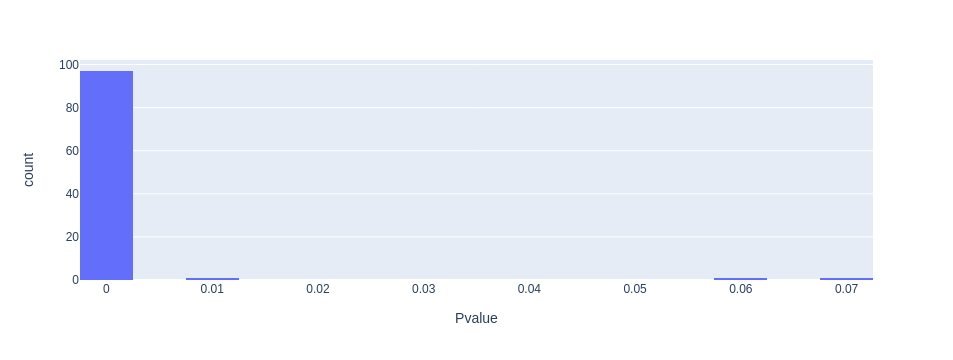

In [62]:
import plotly.express as pxd
fig = px.histogram(df['Pvalue'], x='Pvalue')
fig.show()

# Fisher transformation

In [87]:
from sklearn.preprocessing import MinMaxScaler

def transform_with_fisher(data):
  data = data.reshape(-1, 1)
  scaler = MinMaxScaler((-0.99999,0.99999))
  scaler.fit(data)
  return np.arctanh(scaler.transform(data))

In [89]:
from scipy.stats import normaltest
import numpy as np
results = [normaltest(transform_with_fisher(np.array(df['price']))) for df in dfs]
hypothesis_results=[[value, results[index].statistic[0], results[index].pvalue[0]] for index, value in enumerate(stock_names)]
df=pd.DataFrame(hypothesis_results, columns=['Stock', 'Statistic', 'Pvalue'])
df

,Stock,Statistic,Pvalue
0,AC,654.918759,6.112212e-143
1,ACCELSAB,1659.751576,0.000000e+00
2,ACTINVRB,1418.824162,8.058380e-309
3,AGRO22,278.631912,3.132197e-61
4,AGUA,451.905044,7.414237e-99
...,...,...,...
95,GSANBORB-1,1104.224555,1.662205e-240
96,HCITY,315.452215,3.165351e-69
97,HERDEZ,1842.062800,0.000000e+00
98,HOMEX,398.351556,3.155432e-87


In [90]:
df[df['Pvalue'] > 0.1]

,Stock,Statistic,Pvalue


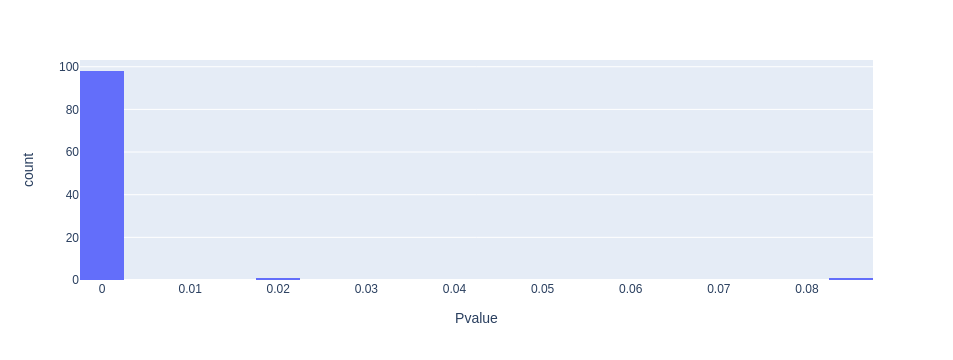

In [91]:
import plotly.express as pxd
fig = px.histogram(df['Pvalue'], x='Pvalue')
fig.show()

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load data
prices = dfs[0]['price'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_prices = scaler.fit_transform(prices)

# Create dataset with sequences
TIME_STEPS = 10
X, Y = [], []
for i in range(len(normalized_prices) - TIME_STEPS):
    X.append(normalized_prices[i:i+TIME_STEPS])
    Y.append(normalized_prices[i+TIME_STEPS])
X = np.array(X)
Y = np.array(Y)


train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(TIME_STEPS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X_train, Y_train, epochs=5, batch_size=1)

# Predict
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(Y_train[:,0], train_predict[:,0]))
print(f"Train Score: {train_score:.2f} RMSE")
test_score = np.sqrt(mean_squared_error(Y_test[:,0], test_predict[:,0]))
print(f"Test Score: {test_score:.2f} RMSE")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2292/2292 [==============================] - 48s 21ms/step - loss: 0.0023
Epoch 2/5
2292/2292 [==============================] - 71s 31ms/step - loss: 3.8876e-04
Epoch 3/5
2292/2292 [==============================] - 71s 31ms/step - loss: 2.8149e-04
Epoch 4/5
2292/2292 [==============================] - 71s 31ms/step - loss: 2.2563e-04
Epoch 5/5
36/36 [==============================] - 0s 12ms/step
Train Score: 1.77 RMSE
Test Score: 2

In [7]:
reproduced_series = []
for i in range(len(normalized_prices) - TIME_STEPS):
    current_sequence = normalized_prices[i:i+TIME_STEPS].reshape(1, TIME_STEPS, 1)
    reproduced_point = model.predict(current_sequence, verbose='0')
    reproduced_series.append(reproduced_point[0][0])

reproduced_series = scaler.inverse_transform(np.array(reproduced_series).reshape(-1, 1))

original_series_to_compare = prices[TIME_STEPS:]

1/1 [==============================] - 0s 10ms/step


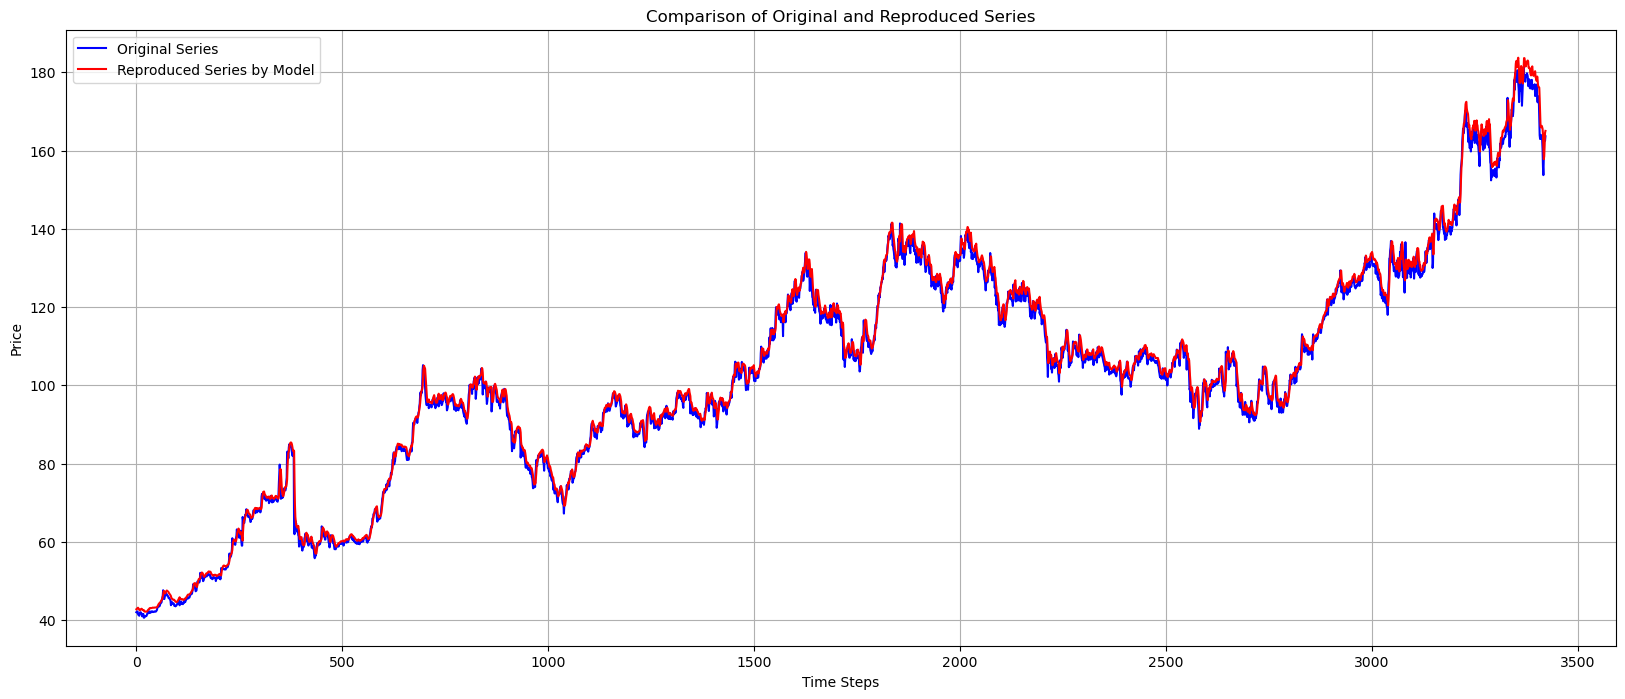

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(original_series_to_compare, label="Original Series", color='blue')
plt.plot(reproduced_series, label="Reproduced Series by Model", color='red')
plt.title('Comparison of Original and Reproduced Series')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

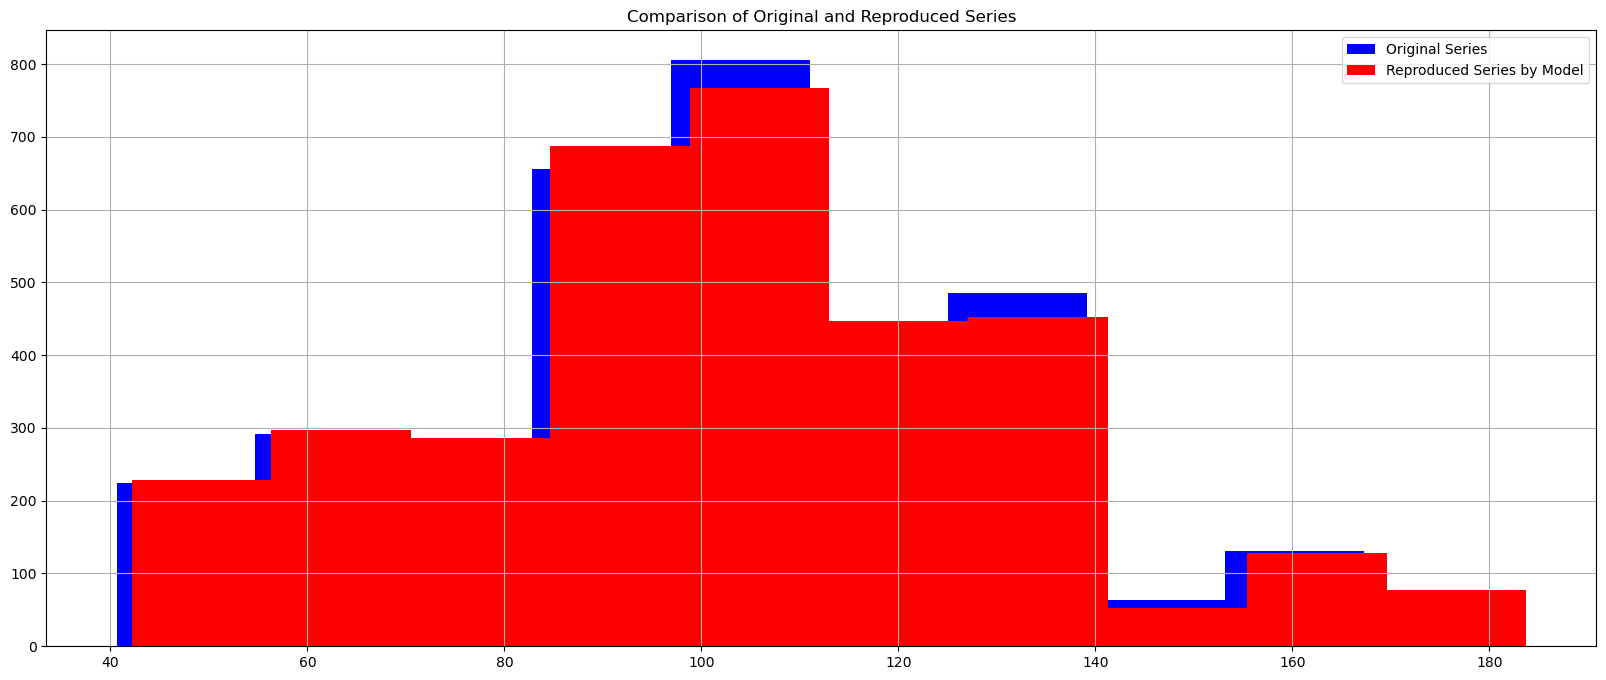

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.hist(original_series_to_compare, label="Original Series", color='blue')
plt.hist(reproduced_series, label="Reproduced Series by Model", color='red')
plt.title('Comparison of Original and Reproduced Series')
plt.legend()
plt.grid(True)
plt.show()